<a href="https://colab.research.google.com/github/WinniePretzel/Project/blob/master/%E2%80%9CNMA_project%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How face expressions were encoded in different brain area


In [4]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [5]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

---
# Visualize reconstructed face movie

svd_time: (7018, 1000)
svd_mask: (240, 320, 1000)


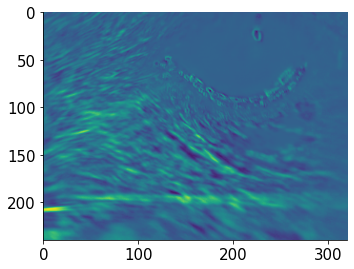

In [7]:
print('svd_time:', dat['beh_svd_time'].shape)
print('svd_mask:', dat['beh_svd_mask'].shape)
# Show reconstructed face movie image
t = 0 # Select the time 
img = dat['beh_svd_mask'] @ dat['beh_svd_time'][t, :]
plt.imshow(img)  

---
# Classifying face patterns

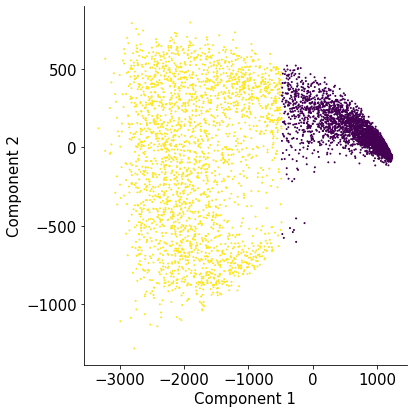

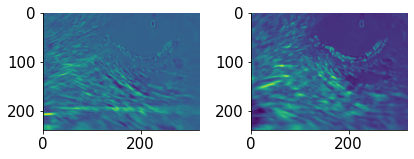

In [8]:
#@title k-means to classify first two conponents of face movie
def visualize_components(component1, component2, labels):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores

  Returns:
    Nothing.

  """

  fig = plt.figure(figsize=(6,6))
  plt.scatter(x=component1, y=component2, c=labels, s=1)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()

# Perform k-means to the first two PCs of face movie
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(dat['beh_svd_time'][:,0:1])

# Visulize the classifying result
visualize_components(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], kmeans.labels_)

# Show a random image from each cluster
clus_0_index = np.where(kmeans.labels_ == 0)[0]
clus_1_index = np.where(kmeans.labels_ == 1)[0]
recon_face_0 = dat['beh_svd_mask'] @ dat['beh_svd_time'][clus_0_index[0], :]
recon_face_1 = dat['beh_svd_mask'] @ dat['beh_svd_time'][clus_1_index[0], :]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,2,1)
plt.imshow(recon_face_0)
ax = plt.subplot(1,2,2)
plt.imshow(recon_face_1)


---
# Visulize pupil area, pupil position and running speed

pupilArea: (7018, 1)
pupilCOM: (7018, 2)
run: (7018, 1)


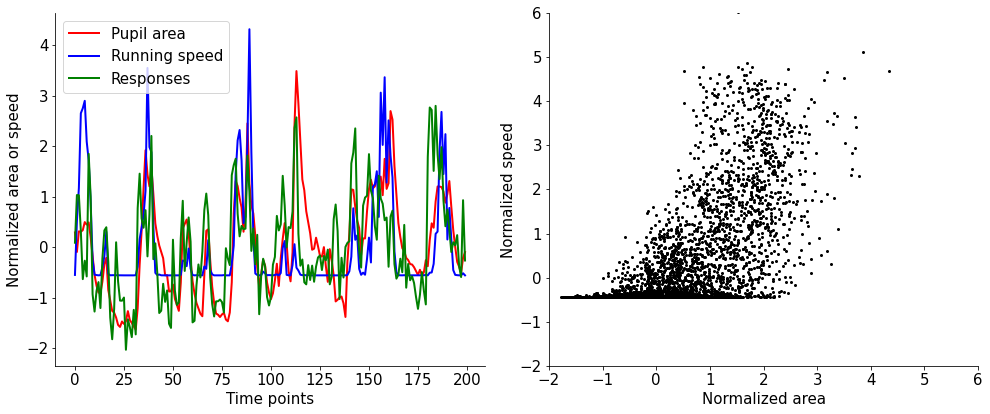

In [18]:
#@title Correlation between pupil area and running speed
print('pupilArea:', dat['pupilArea'].shape)
print('pupilCOM:', dat['pupilCOM'].shape)
print('run:', dat['run'].shape)
from scipy import stats
def visualize_behavior(area, run, sresp):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    area (numpy array of floats) : Vector of area of mice pupil
    run (numpy array of floats) : Vector of running speed of mice
    sresp (numpy array of floats) : vector of neural response of mice

  Returns:
    Nothing.

  """
  fig = plt.figure(figsize=(14,6))
  ax = plt.subplot(1,2,1)
  plt.plot(stats.zscore(area[0:200]), color='red', linewidth=2, 
           label='Pupil area')
  plt.plot(stats.zscore(run[0:200]), color='blue', linewidth=2, 
           label='Running speed')
  plt.plot(stats.zscore(sresp[0:200]), color='green', linewidth=2, 
           label='Responses')
  plt.legend()
  ax.set(xlabel='Time points', ylabel ='Normalized area or speed')

  ax = plt.subplot(1,2,2)
  plt.scatter(stats.zscore(area),stats.zscore(run), color='black', s=4)
  ax.set(xlabel='Normalized area', ylabel ='Normalized speed')
  ax.set(xlim=[-2,6],ylim=[-2,6])

  plt.show()
ave_sresp = np.reshape(np.mean(dat['sresp'].T,axis = 1),(dat['sresp'].shape[1],1))
visualize_behavior(dat['pupilArea'],dat['run'],ave_sresp)
